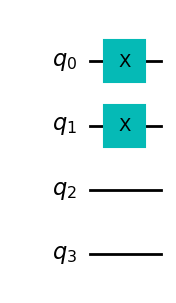

In [28]:

# Import necessary libraries
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import expm
from qiskit import Aer, transpile, assemble
from qiskit.providers.aer import AerSimulator
from qiskit.circuit import QuantumCircuit
from qiskit.quantum_info import Pauli, Statevector, Operator

# Constants and simulation parameters
N_sites = 4  # Number of qubits
delta_m_squared = 0.5
omega_a = np.full(N_sites // 2, delta_m_squared)
omega_b = np.zeros(N_sites // 2)
omega = np.concatenate((omega_a, omega_b))
tolerance = 5e-1
τ = times[1] - times[0]  # Time step
# E = 1
# omega = np.array([delta_m_squared / (2 * E) for _ in range(N_sites)])  # omega for each qubit
B = [0, 0, -1]  # Magnetic field B = [1, 0, 0] for all sites

# Constants for Rogerro's fit (corresponding to Δω = 0.25)
a_t = 1.224
b_t = 0
c_t = 1.62
   
# Define parameters for H_SI
mu = 1.0
interaction_strength = mu / (2 * N_sites)
H_SI = 0
H_vac = 0
for i in range(N_sites -1):
    for j in range(i + 1, N_sites):
        
        # H_vac terms for site i
        Xi = (omega[i] / 2) * B[0] * Pauli(f'{"I"*i}X{"I"*(N_sites-i-1)}').to_matrix()
        Yi = (omega[i] / 2) * B[1] * Pauli(f'{"I"*i}Y{"I"*(N_sites-i-1)}').to_matrix()
        Zi = (omega[i] / 2) * B[2] * Pauli(f'{"I"*i}Z{"I"*(N_sites-i-1)}').to_matrix()
        H_vac += (1/(N_sites-1)) * (Xi + Yi + Zi)
        
        # H_vac terms for site j
        Xj = (omega[j] / 2) * B[0] * Pauli(f'{"I"*j}X{"I"*(N_sites-j-1)}').to_matrix()
        Yj = (omega[j] / 2) * B[1] * Pauli(f'{"I"*j}Y{"I"*(N_sites-j-1)}').to_matrix()
        Zj = (omega[j] / 2) * B[2] * Pauli(f'{"I"*j}Z{"I"*(N_sites-j-1)}').to_matrix()
        H_vac += (1/(N_sites-1))* (Xj + Yj + Zj)
        
        XX = Pauli(f'{"I"*i}X{"I"*(j-i-1)}X{"I"*(N_sites-j-1)}').to_matrix()
        YY = Pauli(f'{"I"*i}Y{"I"*(j-i-1)}Y{"I"*(N_sites-j-1)}').to_matrix()
        ZZ = Pauli(f'{"I"*i}Z{"I"*(j-i-1)}Z{"I"*(N_sites-j-1)}').to_matrix()
        H_SI += interaction_strength * (XX + YY + ZZ)

# Total Hamiltonian H = H_vac + H_SI
H_total = H_vac + H_SI

# Create a quantum circuit for the initial state |1100>
qc = QuantumCircuit(N_sites)
qc.x([0, 1])  # Apply X gate to the first and second qubits to create |1100> state
initial_state = Statevector.from_label('1100')

# Visualize the initial quantum circuit
qc.draw(output='mpl', style='clifford')





Index of the first local minimum: 340
Corresponding time of first minimum index: 3.4034034034034035
Survival probability at first local minimum: 0.33033802294942666
t_p_Rog=  3.3168242980107463


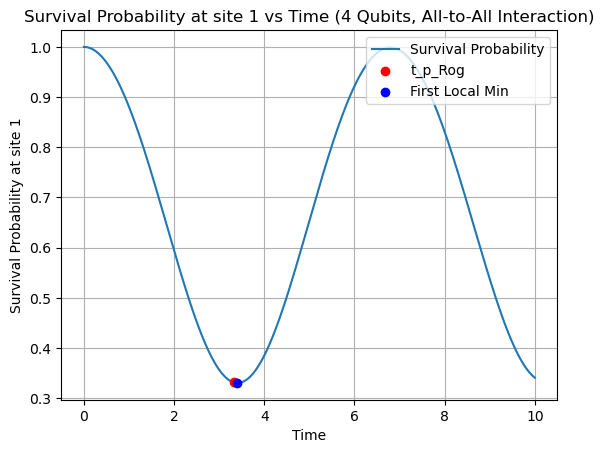

In [31]:
# Define time steps
times = np.linspace(0, 10, 1000)  # Extending the time range to 10
sigma_z_expectations = []

# Simulate the circuit for different time steps
# simulator = AerSimulator()
# simulator = AerSimulator(method='matrix_product_state')
for time in times:
    # Time evolution
    U = Operator(expm(-1j * H_total * time))
    evolved_state = initial_state.evolve(U)
    
    # Measure expectation value of sigma_z on the first qubit
    z_expectation = evolved_state.expectation_value(Pauli('Z') ^ Pauli('I') ^ Pauli('I') ^ Pauli('I')).real
    sigma_z_expectations.append(z_expectation)

# Calculate survival probability
survival_probabilities = (1 - np.array(sigma_z_expectations)) / 2


# Function to find the index of the first local minimum
def find_first_local_minima_index(arr):
    n = len(arr)
    for i in range(1, n - 1):
        if arr[i] < arr[i - 1] and arr[i] < arr[i + 1]:
            return i
    return -1

# Index of the first minimum of the survival probabilities
i_first_local_min = find_first_local_minima_index(survival_probabilities)

# Calculate the corresponding time and survival probability at the first local minimum
if i_first_local_min != -1:
    t_min = times[i_first_local_min]
    min_survival_prob = survival_probabilities[i_first_local_min]
    print(f"Index of the first local minimum: {i_first_local_min}")
    print(f"Corresponding time of first minimum index: {t_min}")
    print(f"Survival probability at first local minimum: {min_survival_prob}")
else:
    print("No local minimum found in the array.")
    
t_p_Rog = a_t * np.log(N_sites) + b_t * np.sqrt(N_sites) + c_t
print("t_p_Rog= ", t_p_Rog)

# Assert condition
assert abs(t_min - t_p_Rog) < τ + tolerance, "The time of the first minimum survival probability is not within the expected range."

# Plot the survival probability at site 1 against time
plt.plot(times, survival_probabilities, label='Survival Probability')
plt.xlabel('Time')
plt.ylabel('Survival Probability at site 1')
plt.title('Survival Probability at site 1 vs Time (4 Qubits, All-to-All Interaction)')

# Add scatter point for Rogerro's fit
plt.scatter([t_p_Rog], [survival_probabilities[np.abs(times - t_p_Rog).argmin()]], color='red', label="t_p_Rog", zorder=5)

# Add scatter point for the first local minimum
if i_first_local_min != -1:
    plt.scatter([t_min], [min_survival_prob], color='blue', label="First Local Min", zorder=5)

plt.legend(loc="upper right")
plt.grid(True)
plt.show()